In [1]:
from sympy import *
from sympy.physics.control.lti import TransferFunction

from mna.element import *
from mna.element.active import VoltageSource
from mna.netlist.data import Netlist
from mna.netlist.solver import Solver

init_printing()


## Passive RC low-pass filter

Let's define a simple RC filter circuit. The entrypoint of the library is the "netlist", which is a linear representation of the circuit by specifying its components and connect them to arbitrary nodes.

By convention, ground is node 0.

In [2]:
R, C = symbols('R C', real=True, positive=True)

vin = Symbol('V_in')
net = Netlist(instances=[
    # NOTE: Voltage sources are defined with their positive pin first
    VoltageSource('V1', 1, 0, vin),
    Resistor("R1", 1, 2, R),
    Capacitor("C1", 2, 0, C),
])
solver = Solver(net)

Now we can start manipulating the math. A first step could be to show the derived state matrix:

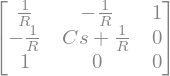

In [3]:
solver.get_matrix()

We can also derive the input vector $\vec{x}$ and output vector $\vec{z}$:

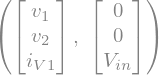

In [4]:
solver.x, solver.z

And we can solve the equation for all variables

In [5]:
from IPython.display import Math
soldict = solver.solve()

# Pretty-display of a list of equations
inner = "\n".join([f"{latex(l)} &= {latex(r)} \\\\" for l,r in soldict.items()])

Math('\\begin{aligned}'+inner+'\\end{aligned}')

<IPython.core.display.Math object>

We can generate a `TransferFunction` from the `sympy.physics.controls.lti` module:

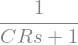

In [6]:
H = solver.transfer_function(vin, net.v[2])
H

The `TransferFunction` is a standard Sympy object, and you can further manipulate it. We can also use other features of the Controls API, for example to show a bode plot or a pole-zero diagram:

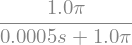

In [7]:
# 1. Compute coefficient for a 1000 Hz RC low-pass filter, and specialize the transfer function
f0 = 1e3
c = 1e-9
r = 1/(2*pi*f0*c)

Hinst = H.subs({R: r, C: c}).simplify()
Hinst

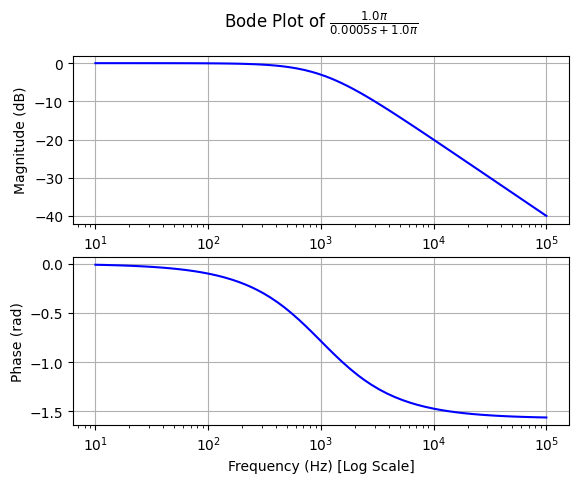

In [8]:
from sympy.physics.control.control_plots import bode_plot, pole_zero_plot

bode_plot(Hinst, initial_exp=1, final_exp=5, freq_unit='Hz')

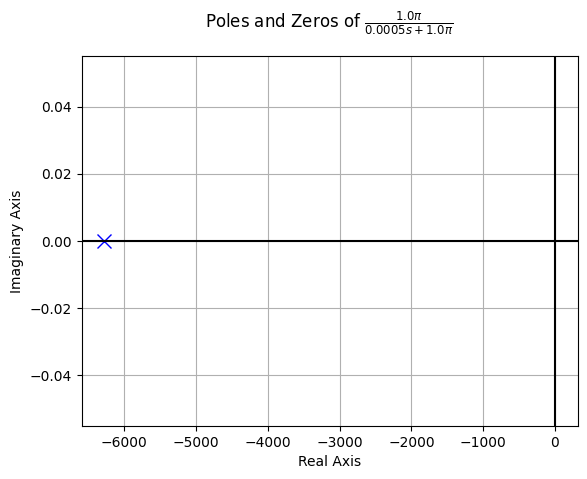

In [9]:
pole_zero_plot(Hinst)

# 2. Sallen-Key topology

One of the more famous filter topologies is the Sallen-Key filter, which depending on the components can make a low-pass, band-pass or high-pass filter.

Let's derive the general transfer function of the filter, using generic impedences:

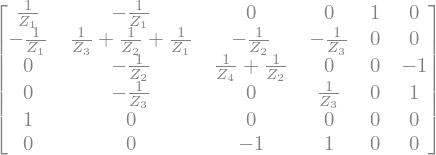

In [10]:
z1, z2, z3, z4 = symbols('Z_1 Z_2 Z_3 Z_4', complex=True)
vin = symbols('v_in', real=True)
sk = Netlist([
    VoltageSource('Vin', 1, 0, vin),
    Resistor('Z_1', 1, 2, z1),
    Resistor('Z_2', 2, 3, z2),
    Resistor('Z_3', 4, 2, z3),
    Resistor('Z_4', 0, 3, z4),
    OpAmp('O_1', 3, 4, 4),
])
sol = Solver(sk)
sol.get_matrix()

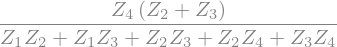

In [15]:
H = sol.transfer_function(vin, sk.v[4])
H

Let's specialize the filter to be a high-pass filter, which means settings $Z_1$ and $Z_2$ as capacitors, and $Z_3$ and $Z_4$ as potentiometers (modeled as parametrized resistors here). We'll set the cutoff frequency $f_0$ and the "quality factor" $Q$ as parameters, use capacitors of $1\ nF$, and solve for the potentiometers.

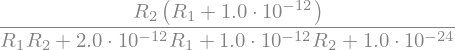

In [36]:
f0, q, r1, r2 = symbols('f_0 Q R_1 R_2', real=True, positive=True)
w0 = 2 * pi * f0
c1 = c2 = 1e-12

H_hp = H.subs({z1:c1, z2:c2, z3:r1,z4:r2})
H_hp

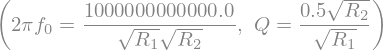

In [37]:
eq_f0 = Eq(w0, 1/sqrt(r1*r2*c1*c2))
eq_q = Eq(q, sqrt(r1*r2*c1*c2)/(r1*(c1+c2)))
eq_f0, eq_q

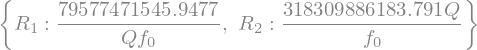

In [38]:
from collections import ChainMap

subs_r = solve([eq_f0, eq_q], r1, r2, c1, c2, dict=True)
subs_r = dict(ChainMap(*subs_r))
subs_r

Now that we have our substitutions for the values of $R_1$ and $R_2$, we can further specialize our transfer function equation:

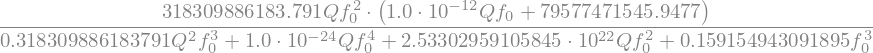

In [41]:
H_hp_inst = H_hp.subs(subs_r).simplify()
H_hp_inst

We're almost ready to show a bode plot; with the transfer function parametrized we can simply substitute our values of $f_0$ and $Q$ to constants.

For this example, we'll target a 3500 Hz cutoff with a Q of 2.

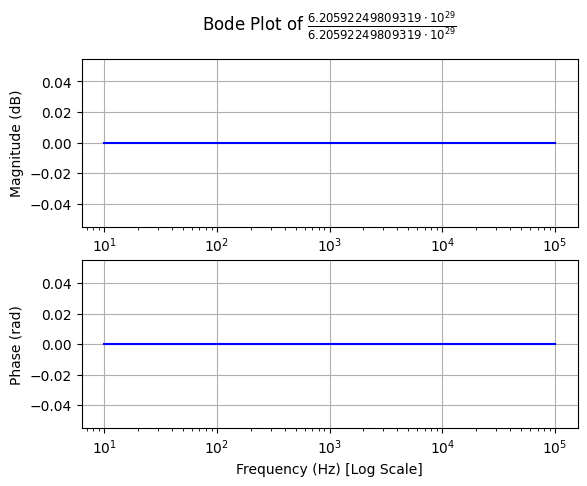

In [43]:
bode_plot(H_hp_inst.subs({f0: 3500, q: 2}), freq_unit='Hz', initial_exp=1)